# Описание проекта
Требуется разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

В некоторых странах, где работает заказчик, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

This image is unavailable in your country in compliance with local laws

Таке надо включить проверку, исключающую вывод запрещённого контента, в данном случае - изображений несовершеннолетних.


##  Описание данных
Данные лежат в папке /datasets/image_search/ или доступны по ссылке.
  
В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
  
В папке train_images содержатся изображения для тренировки модели.
  
В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

Имя файла изображения.  
Идентификатор описания.  
Доля людей, подтвердивших, что описание соответствует изображению.  
Количество человек, подтвердивших, что описание соответствует изображению.  
Количество человек, подтвердивших, что описание не соответствует изображению.  
В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:  

Имя файла изображения.  
Идентификатор описания.  
3, 4, 5 — оценки трёх экспертов.  
  
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.
  
В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
  
В папке test_images содержатся изображения для тестирования модели.

## Интсрументы
torch  
CLIP sentence_transformers
pandas  
PIL  
sklearn  
Catboost  

<!-- vscode-markdown-toc -->

<!-- vscode-markdown-toc-config
	numbering=true
	autoSave=true
	/vscode-markdown-toc-config -->
<!-- /vscode-markdown-toc -->

In [1]:
import pandas as pd
import numpy as np
import random
import PIL
import matplotlib.pyplot as plt
from textwrap import wrap
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import warnings
import glob
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
import time
from tqdm import trange

e:\Data\_Projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка данных

In [2]:
PATH='E:/Data/_Projects/datasets/dsplus_integrated_project_4/to_upload/'

In [3]:
df_crowd = pd.read_csv (PATH+"CrowdAnnotations.tsv", sep="\t")
df_crowd.columns=['file','id','share','matched','unmatched']
df_crowd.sample(5)


file                           id     share  \
17230  2718495608_d8533e3ac5.jpg  1167669558_87a8a467d6.jpg#2  0.333333   
32310  3384314832_dffc944152.jpg  3540416981_4e74f08cbb.jpg#2  0.000000   
963    1248940539_46d33ed487.jpg  1356796100_b265479721.jpg#2  0.000000   
19707  2885387575_9127ea10f1.jpg   293327462_20dee0de56.jpg#2  0.000000   
13044  2502905671_c6039804ab.jpg  3016606751_0e8be20abd.jpg#2  0.000000   

       matched  unmatched  
17230        1          2  
32310        0          3  
963          0          3  
19707        0          3  
13044        0          3

In [4]:
print('Всего строк в наборе данных с оценками толпы', len(df_crowd))
print('Всего уникальных картинок ', len(df_crowd['file'].unique()))

Всего строк в наборе данных с оценками толпы 47829
Всего уникальных картинок  1000


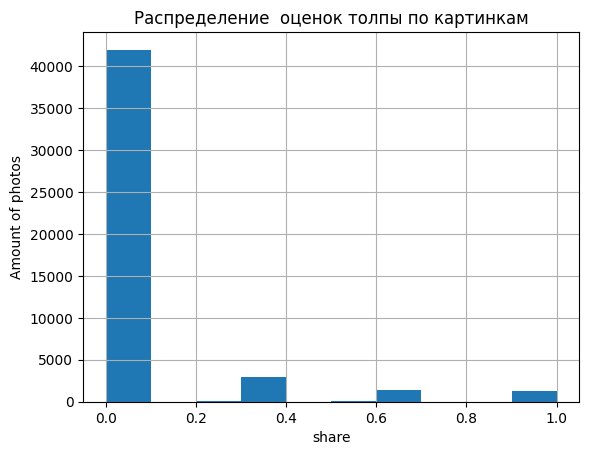

In [5]:
df_crowd['share'].hist(bins=10)
plt.title('Распределение  оценок толпы по картинкам')
plt.xlabel('share')
plt.ylabel('Amount of photos')
plt.show()

In [6]:
df_exp = pd.read_csv (PATH+"ExpertAnnotations.tsv", sep="\t")
df_exp.columns=['file','id','exp1','exp2','exp3']
df_exp.sample(5)

file                           id  exp1  exp2  exp3
644   1982852140_56425fa7a2.jpg   106490881_5a2dd9b7bd.jpg#2     2     3     3
5400   497791037_93499238d8.jpg  2731171552_4a808c7d5a.jpg#2     1     1     2
1000  2225231022_1632d0a5aa.jpg  3504881781_6a842e043b.jpg#2     1     1     2
4079  3432550415_e7b77232de.jpg  2884420269_225d27f242.jpg#2     1     1     2
1878   261490838_2f3ac98b12.jpg  2101457132_69c950bc45.jpg#2     1     2     2

In [7]:
print('Всего строк в наборе данных с оценками экспертов', len(df_exp))
print('Всего уникальных картинок ', len(df_exp['file'].unique()))

Всего строк в наборе данных с оценками экспертов 5821
Всего уникальных картинок  1000


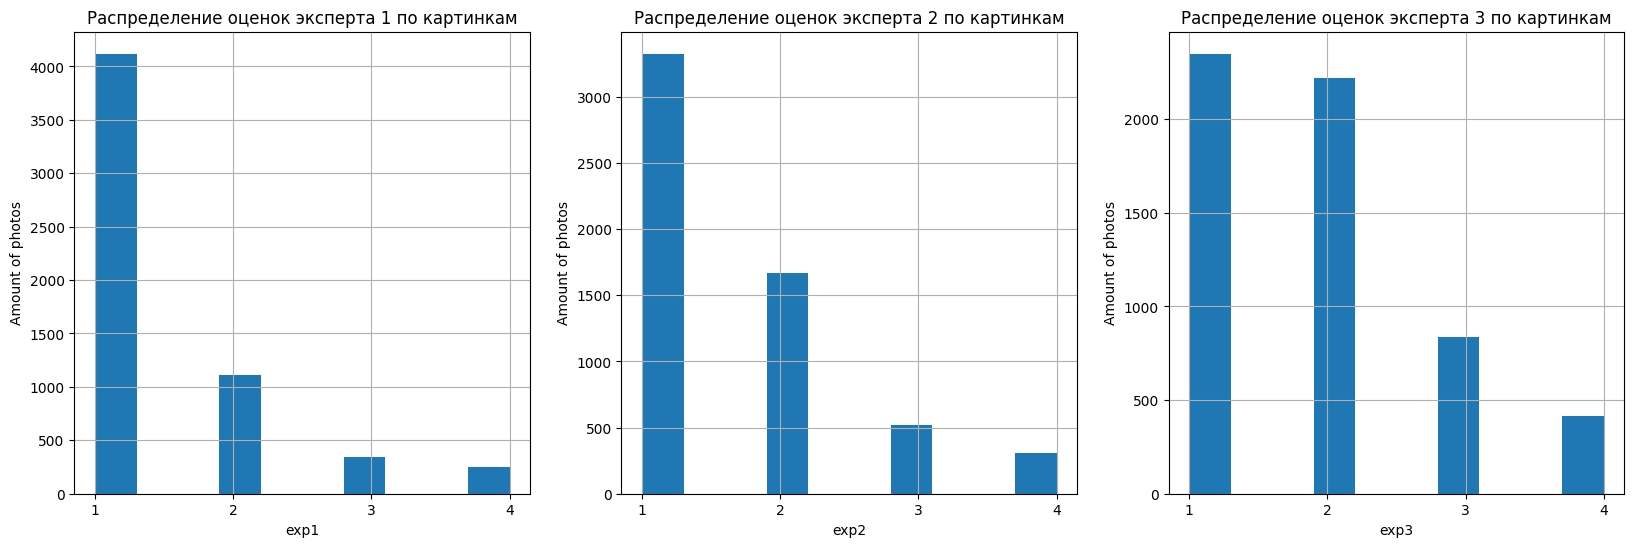

In [8]:
exps = ['exp1','exp2','exp3']
f, axs = plt.subplots(1, 3, figsize=(20, 6))
j = 1
for e in exps:
    plt.subplot (1, 3,j)
    df_exp[e].hist(bins=10)
    plt.title('Распределение оценок эксперта '+str(j)+' по картинкам')
    plt.xlabel(e)
    plt.xticks([1,2,3,4])
    plt.ylabel('Amount of photos')
    j = j + 1
plt.show()

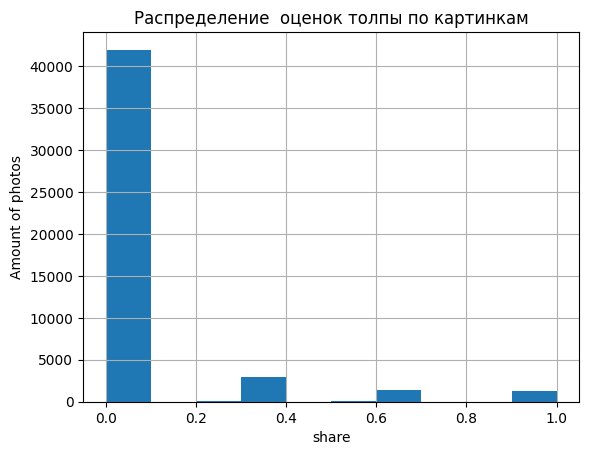

In [9]:

df_crowd['share'].hist(bins=10)
plt.title('Распределение  оценок толпы по картинкам')
plt.xlabel('share')
plt.ylabel('Amount of photos')
plt.show()

In [10]:
train_df=pd.read_csv(PATH+"train_dataset.csv",sep=',')
train_df.columns=['file','id','query_text']
train_df.sample(5)

file                           id  \
3650  3030566410_393c36a6c5.jpg  3433982387_3fa993cf5a.jpg#2   
2017   488408004_a1e26d4886.jpg  1472230829_803818a383.jpg#2   
950   2484190118_e89363c465.jpg  3593392955_a4125087f6.jpg#2   
2501   308487515_7852928f90.jpg  3227148358_f152303584.jpg#2   
798   2910758605_73a3f5a5c2.jpg  3218480482_66af7587c8.jpg#2   

                                             query_text  
3650  A young girl in a white dress watches bubbles ...  
2017                            Rafting boat on river .  
950       Two dogs run down a dirt path in the forest .  
2501             A large white bird flying over water .  
798   A Miami basketball player dribbles by an Arizo...

In [11]:
print('Всего строк в обучающем наборе данных ', len(train_df))
print('Всего уникальных картинок ', len(train_df['file'].unique()))
print('Всего уникальных описаний ', len(train_df['query_text'].unique()))

Всего строк в обучающем наборе данных  5822
Всего уникальных картинок  1000
Всего уникальных описаний  977


In [12]:
#Напишем функцию для визуализации изображений
def show_scored_images(df,col):
    d=df.copy()
    for i in d[col].unique():
        sub=d[d[col] == i]

        sub=sub[[col,'file','query_text']]
        sub=sub.drop_duplicates()
        fig = plt.figure(figsize=(9,5))
        print(col,"=",i)
        le=min(5,len(sub))
        for j in range(le):
            idx=random.randint(1,len(sub))-1
            query=str(sub.iloc[idx]['query_text'])
            fig.add_subplot(1, 5, j + 1)
            img=PIL.Image.open(PATH+'/train_images/' + str(sub.iloc[idx]['file']))
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.title(label = "\n".join(wrap(query,25)),loc='center', fontsize = 8, fontweight = 'light', pad = 10)

        plt.show()



In [27]:
df=pd.merge(train_df, df_exp, how='outer', left_on=['file','id'], right_on=['file','id'])
df=pd.merge(df, df_crowd, how='outer', left_on=['file','id'], right_on=['file','id'])
df=df[['file','id','query_text','exp1','exp2','exp3','share','matched','unmatched']]
df.sample(5)

file                           id                                         query_text  exp1  exp2  exp3     share  matched  unmatched
12798  2196107384_361d73a170.jpg    56489627_e1de43de34.jpg#2                                                NaN   NaN   NaN   NaN  0.000000      0.0        3.0
14841  2317714088_bcd081f926.jpg  3397220683_4aca010f86.jpg#2                                                NaN   NaN   NaN   NaN  0.000000      0.0        3.0
1573   1352410176_af6b139734.jpg  3472364264_dbde5a8d0a.jpg#2  a large dog runs on the beach with something h...   1.0   1.0   1.0       NaN      NaN        NaN
16852  2450453051_f1d4a78ab4.jpg   524282699_71e678a6bd.jpg#2                                                NaN   NaN   NaN   NaN  0.000000      0.0        3.0
49021   533979933_a95b03323b.jpg  2183227136_8bb657846b.jpg#2                                                NaN   NaN   NaN   NaN  0.666667      2.0        1.0

In [28]:
df=df.drop_duplicates()

# Знакомство с датасетом

In [29]:
df.isna().sum()

file              0
id                0
query_text    45500
exp1          45501
exp2          45501
exp3          45501
share          3493
matched        3493
unmatched      3493
dtype: int64

In [30]:
pd.set_option('display.expand_frame_repr', False)
df.describe()

exp1         exp2         exp3         share       matched     unmatched
count  5821.000000  5821.000000  5821.000000  47829.000000  47829.000000  47829.000000
mean      1.436695     1.624463     1.882151      0.068766      0.208430      2.820214
std       0.787130     0.856256     0.904091      0.207490      0.628775      0.656556
min       1.000000     1.000000     1.000000      0.000000      0.000000      0.000000
25%       1.000000     1.000000     1.000000      0.000000      0.000000      3.000000
50%       1.000000     1.000000     2.000000      0.000000      0.000000      3.000000
75%       2.000000     2.000000     2.000000      0.000000      0.000000      3.000000
max       4.000000     4.000000     4.000000      1.000000      5.000000      6.000000

Теперь проишла пора заполнить пропуски и создать сводную оценку для каждой пары "картинка+описание".
У нас почти по всем парам есть оценка толпы и кое-где встречаются оценки экспертов, на точность которых надежда больше.  
Определим сводную оценку по экспертам. Выберем ту цифру, которую поставило большинство. Если все оценки разные - выберем медиану.  
Там где есть оценка эксперта рассчитает надбавку по следующей схеме:  
Оценка эксперта 1 - надбавка=0.00;  
Оценка эксперта 2 - надбавка=0.33;  
Оценка эксперта 3 - надбавка=0.66;  
Оценка эксперта 4 - надбавка=1.00;  
Сложим надбавку и оценку толпы.  
*Если оценки толпы нет, то берём только оценку толпы.*  
Полученную сумму приведём к значениям в интервале [0:1]  


In [31]:
def count_most_frequent(row):
    row=row[['exp1','exp2','exp3']]
    values, counts = np.unique(row, return_counts=True)

    if len(counts) == 0 or all(count == 1 for count in counts):
        return np.median(row)

    most_frequent_value = values[np.argmax(counts)]
    return most_frequent_value
df['most_frequent'] = df.apply(count_most_frequent, axis=1)
df.head(9)

file                           id                                         query_text  exp1  exp2  exp3  share  matched  unmatched  most_frequent
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   NaN   NaN   NaN    0.0      0.0        3.0            NaN
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   2.0   2.0    0.0      0.0        3.0            2.0
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   4.0   4.0   4.0    1.0      3.0        0.0            4.0
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   2.0   2.0   3.0    0.0      0.0        3.0            2.0
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0

In [32]:
df['addon']=df['most_frequent'].apply(lambda x: (x-1)/3)
df.head(9)

file                           id                                         query_text  exp1  exp2  exp3  share  matched  unmatched  most_frequent     addon
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   NaN   NaN   NaN    0.0      0.0        3.0            NaN       NaN
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   2.0   2.0    0.0      0.0        3.0            2.0  0.333333
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   4.0   4.0   4.0    1.0      3.0        0.0            4.0  1.000000
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   2.0   2.0   3.0    0.0      0.0        3.0            2.0  0.333333
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000

In [33]:
df['score'] = df[['share','addon']].max(axis = 1)
maxx=df['score'].max()
df['score']=round(df['score']/maxx,2)
df.head(9)

file                           id                                         query_text  exp1  exp2  exp3  share  matched  unmatched  most_frequent     addon  score
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   NaN   NaN   NaN    0.0      0.0        3.0            NaN       NaN   0.00
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000   0.00
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   2.0   2.0    0.0      0.0        3.0            2.0  0.333333   0.33
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   4.0   4.0   4.0    1.0      3.0        0.0            4.0  1.000000   1.00
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000   0.00
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   2.0   2.0   3.0    0.0      0.0        3.0            2.0  0.333333   0.33
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000   0.00
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000   0.00
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2  A young child is wearing blue goggles and sitt...   1.0   1.0   1.0    NaN      NaN        NaN            1.0  0.000000   0.00

In [35]:
dictionary = dict(zip(list(train_df['id']), list(train_df['query_text'])))

In [36]:
df['query_text'] = df['query_text'].fillna(df['id'].apply(lambda x: dictionary.get(x)))
df.tail(5)

file                          id                                         query_text  exp1  exp2  exp3     share  matched  unmatched  most_frequent  addon  score
51317  997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2                     Two girls with orange shirts .   NaN   NaN   NaN  0.000000      0.0        3.0            NaN    NaN   0.00
51318  997722733_0cb5439472.jpg  544576742_283b65fa0d.jpg#2                   A woman in jeans rock climbing .   NaN   NaN   NaN  0.333333      1.0        2.0            NaN    NaN   0.33
51319  997722733_0cb5439472.jpg  872622575_ba1d3632cc.jpg#2         A man is climbing the side of a mountain .   NaN   NaN   NaN  1.000000      3.0        0.0            NaN    NaN   1.00
51320  997722733_0cb5439472.jpg  888425986_e4b6c12324.jpg#2                      A person flipping upside down   NaN   NaN   NaN  0.000000      0.0        3.0            NaN    NaN   0.00
51321  997722733_0cb5439472.jpg  997722733_0cb5439472.jpg#2  A person in a red shirt climbing up a rock fac...   NaN   NaN   NaN  0.666667      2.0        1.0            NaN    NaN   0.67

In [37]:
df = df[df['query_text'].notna()]
df = df[['file','query_text','score','id']]
df.shape

(50213, 4)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50213 entries, 0 to 51321
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file        50213 non-null  object 
 1   query_text  50213 non-null  object 
 2   score       50213 non-null  float64
 3   id          50213 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [39]:
df.sample(3)

file                                         query_text  score                           id
17888   249394748_2e4acfbbb5.jpg    A dog wearing a red harness runs across a field    0.0  2280525192_81911f2b00.jpg#2
41045  3545586120_283d728a97.jpg  A man wearing glasses and his black and white ...    0.0  2944836001_b38b516286.jpg#2
50440   757332692_6866ae545c.jpg  A white dog is running on gravel away from two...    0.0   500446858_125702b296.jpg#2

score = 0.0


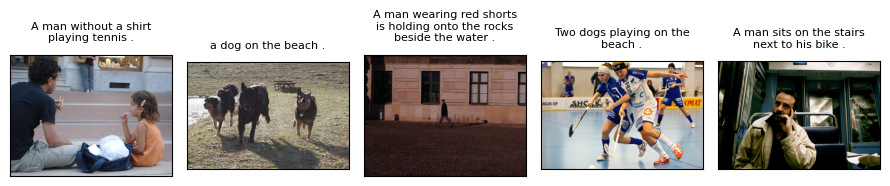

score = 0.33


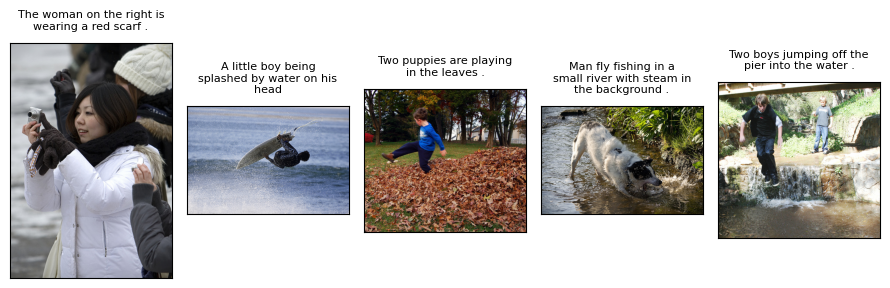

score = 1.0


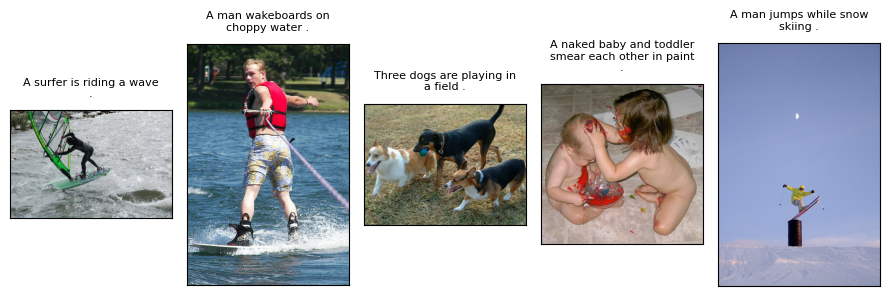

score = 0.67


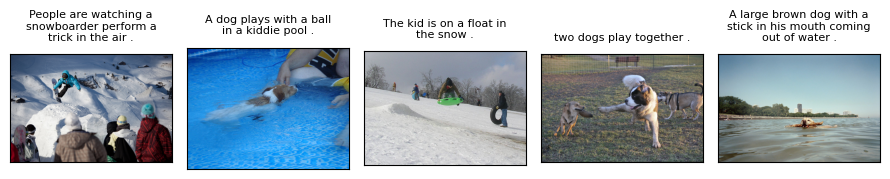

score = 0.25


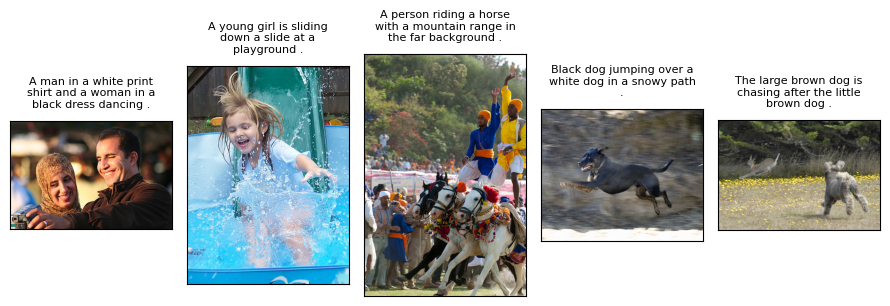

score = 0.75


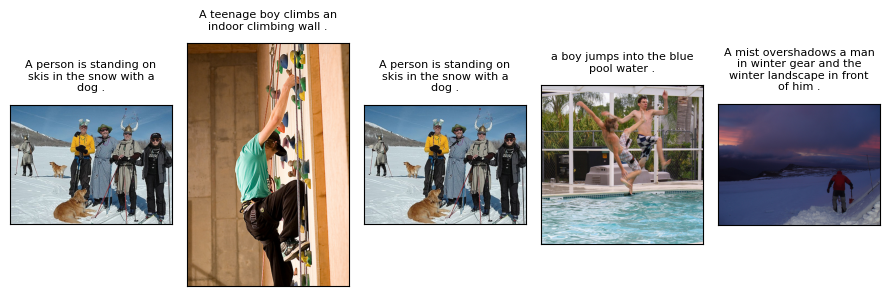

score = 0.8


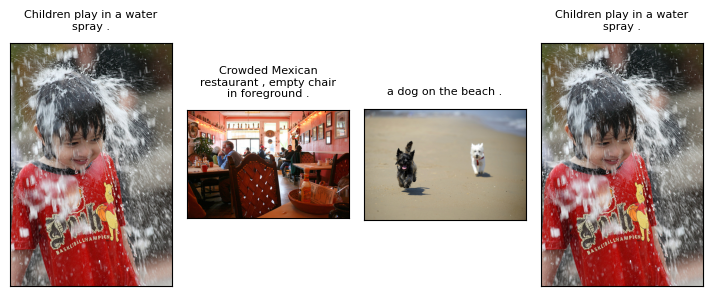

score = 0.5


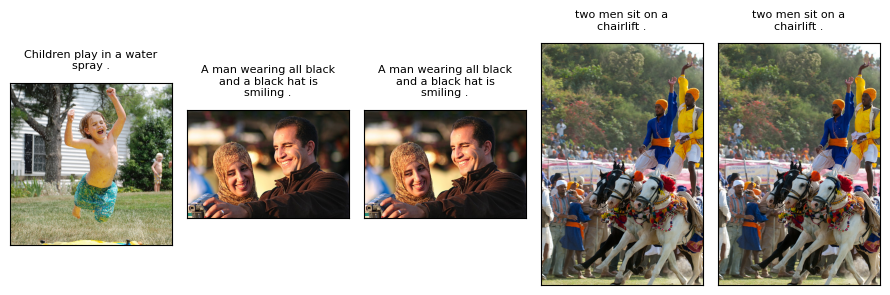

score = 0.6


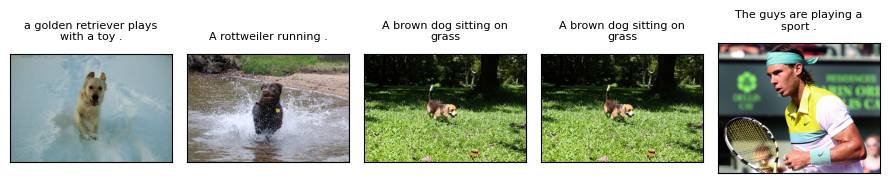

score = 0.2


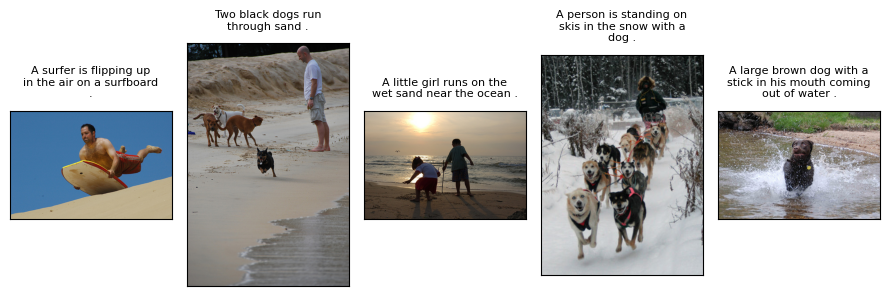

score = 0.4


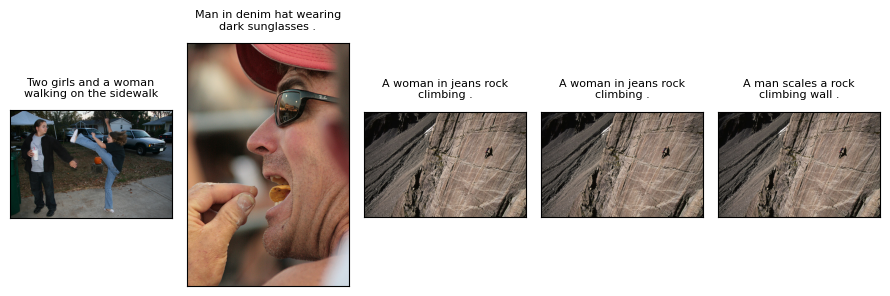

score = 0.17


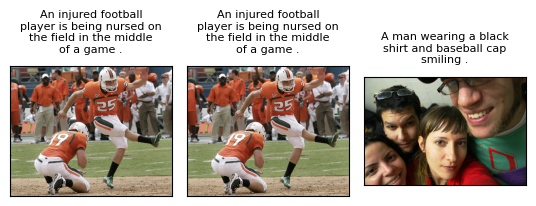

In [40]:
show_scored_images(df,'score')

Сводная оценка вполне точно отражает соответствие описание картинке. На этом материале можно обучить нейросеть.

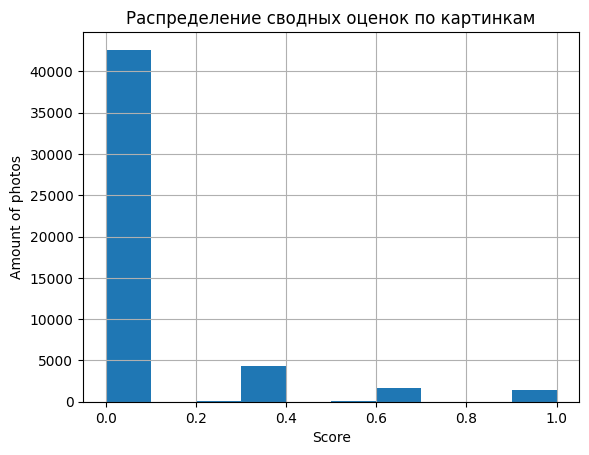

In [41]:
df['score'].hist(bins = 10)
plt.title('Распределение сводных оценок по картинкам')
plt.xlabel('Score')
plt.ylabel('Amount of photos')
plt.show()

В результате мы получили достаточно гармоничный график, с пиком в районе нуля, так как из всех описаний к картинкам реально подходят лишь немногие, потом идёт резкий почти гиперболический спуск к и с отскокакми в районе 0.3 и 0,6 за счёт надбавки за оценку экспертами. Данных много и они разнообразны, этого должно хватить для обучения нейросети.

## Фильтрация детского контента

In [42]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [43]:
stopset={'adolescent',
            'boy','boys',
            'child','children',
            'daughter','daughters',
            'female_child',
            'girl','girls',
            'junior','juniors',
            'kid','kids',
            'kyd',
            'male_child',
            'minor','minors',
            'offspring','offsprings',
            'son','sons',
            'toddler','toddlers'
            'underage','baby','babies',
            'youngsters','teenager','teenagers'}

In [44]:
def content_filter(df):
     df['query_text']=df['query_text'].apply(lambda x: x.lower())
     df['is_censored']= df['query_text'].apply(lambda x: 1 if any(word in stopset for word in x.split()) else 0)
     return df

In [45]:
df=content_filter(df)

In [46]:
select=df[df['is_censored']==1]
select['bad_file']=select['id'].apply(lambda x: str(x)[:-2])
bad_list=select['bad_file'].unique()
bad_list=set(bad_list)
df = df[~df['file'].isin(bad_list)]
df.sample(5)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5352\548064944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select['bad_file']=select['id'].apply(lambda x: str(x)[:-2])


file                                         query_text  score                           id  is_censored
12958  2204550058_2707d92338.jpg  a woman wearing black clothes , a purple scarf...   0.00  2073964624_52da3a0fc4.jpg#2            0
43071  3610683688_bbe6d725ed.jpg  a black dog standing in shallow water with a p...   0.00   505929313_7668f021ab.jpg#2            0
42129  3585598356_8ce815bbb9.jpg    two boys talking while wearing unique outfits .   0.00  3694064560_467683205b.jpg#2            1
869    3499720588_c32590108e.jpg  a woman is reading literature and sitting on t...   0.00  3729525173_7f984ed776.jpg#2            0
23475  2822290399_97c809d43b.jpg                a dog runs through the long grass .   0.33   494792770_2c5f767ac0.jpg#2            0

Теперь мы исключили из набора данных всё, что содержит запрещённый контент. Можем начинать готовить данные для обучения модели.

# Векторизация изображений и текстовых описаний

## Векторизация изображений

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('clip-ViT-B-32')

In [48]:
torch.set_num_threads(4)

In [49]:
def verctorize_files(dir='train_images'):
    img_names = list(glob.glob(PATH+dir+'/*.jpg'))
    img_emb = model.encode([PIL.Image.open(filepath) for filepath in img_names], convert_to_tensor=True, show_progress_bar=True)
    img_df=pd.DataFrame()
    img_df['img_features'] = [np.array(y) for y in img_emb.cpu()]
    img_df['path']=img_names
    img_df['file']=img_df['path'].apply(lambda x: str(x.split('_images')[-1])[1:])
    return img_df




In [50]:
img_df=verctorize_files(dir='train_images')
img_df.sample(5)

Batches: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


img_features                                               path                       file
106  [0.044364497, 0.09219866, -0.021125682, 0.3028...  E:/Data/_Projects/datasets/dsplus_integrated_p...  1998457059_c9ac9a1e1a.jpg
389  [-0.24732947, 0.22171299, 0.037615642, 0.14317...  E:/Data/_Projects/datasets/dsplus_integrated_p...  2844641033_dab3715a99.jpg
978  [-0.19698595, 0.15615743, 0.060363196, 0.11078...  E:/Data/_Projects/datasets/dsplus_integrated_p...   757046028_ff5999f91b.jpg
471  [0.072913855, 0.12344147, -0.29539374, 0.11839...  E:/Data/_Projects/datasets/dsplus_integrated_p...  3015863181_92ff43f4d8.jpg
67   [0.067341186, 0.4905917, 0.13282318, -0.356706...  E:/Data/_Projects/datasets/dsplus_integrated_p...  1499581619_a5f65a882c.jpg

## Векторизация текстовых описаний

In [51]:
def vextrize_description(df):
    query_emb = model.encode(list(df['query_text']), convert_to_tensor=True, show_progress_bar=False)
    df['text_features']=[np.array(xi) for xi in query_emb.cpu()]
    return df

In [52]:
df=vextrize_description(df)
df.head(3)

file                                         query_text  score                           id  is_censored                                      text_features
0  1056338697_4f7d7ce270.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...
1  1262583859_653f1469a9.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...
4  2621415349_ef1a7e73be.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...

In [53]:
result = pd.merge(df, img_df, how="left", on="file")
result.head()

file                                         query_text  score                           id  is_censored                                      text_features                                       img_features                                               path
0  1056338697_4f7d7ce270.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...  [0.5297142, 0.50786495, -0.014293803, 0.005954...  E:/Data/_Projects/datasets/dsplus_integrated_p...
1  1262583859_653f1469a9.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...  [0.008751422, 0.65640306, -0.0041738525, 0.585...  E:/Data/_Projects/datasets/dsplus_integrated_p...
2  2621415349_ef1a7e73be.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...  [-0.0038780868, 0.13201106, -0.011517612, 0.25...  E:/Data/_Projects/datasets/dsplus_integrated_p...
3  3155451946_c0862c70cb.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...  [-0.1959048, 0.3497538, 0.43747264, -0.0770149...  E:/Data/_Projects/datasets/dsplus_integrated_p...
4  3222041930_f642f49d28.jpg  a young child is wearing blue goggles and sitt...    0.0  2549968784_39bfbe44f9.jpg#2            1  [-0.0746352, 0.20491645, -0.2015314, 0.3129072...  [-0.38799834, 0.48299533, 0.22359428, -0.26786...  E:/Data/_Projects/datasets/dsplus_integrated_p...

*Вывод*:  
Теперь у нас есть единый датасет, где каждой картинке и каждому текстовому описанию присвое вектор, подходящий для машинного обучения, и есть целевая переменная, показывающая, насколько хорошо они соответствуют друг-другу.


# Моделирование

## Разделим выборку на обучающий и тестовый набор

In [54]:
def count_vec_dist(df):
    df['evql']=0
    df['mnh']=0
    df['chbsh']=0
    df['cos']=0
    for i in trange(len(df)):
        vector1=np.ascontiguousarray(df['img_features'][i]).astype('float64')
        vector2=np.ascontiguousarray(df['text_features'][i]).astype('float64')
        #Евклидово расстояние
        df['evql'][i]=np.linalg.norm(vector1-vector2)
        #Манхэттенское расстояние
        df['mnh'][i]=np.sum(np.abs(vector1-vector2))
        #Расстояние Чебышева
        df['chbsh'][i]=np.abs(vector1-vector2).max()
        #Косинус включенного угла
        df['cos'][i]=(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*(np.linalg.norm(vector2)))).astype('float64')
    return(df)

In [55]:
dfa=count_vec_dist(result)

  0%|          | 0/35912 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_5352\3128220890.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['evql'][i]=np.linalg.norm(vector1-vector2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5352\3128220890.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mnh'][i]=np.sum(np.abs(vector1-vector2))
C:\Users\Admin\AppData\Local\Temp\ipykernel_5352\3128220890.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [56]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

In [57]:
dfa.iloc[0][['evql','mnh','chbsh','cos']]

evql      12.880197
mnh      187.710105
chbsh      7.129032
cos        0.098729
Name: 0, dtype: object

In [58]:
train_index, val_index=next(gss.split(X=dfa[['evql','mnh','chbsh','cos']], y=dfa['score'], groups=dfa['file']))
X_train=dfa.iloc[train_index][['evql','mnh','chbsh','cos']]
X_val=dfa.iloc[val_index][['evql','mnh','chbsh','cos']]

y_train=dfa.iloc[train_index]['score']
y_val=dfa.iloc[val_index]['score']


In [59]:
X_train=np.array(X_train)
X_val=np.array(X_val)

In [60]:
sc=StandardScaler()
dum_tr_X=sc.fit_transform(X_train)
dum_val_X=sc.transform(X_val)

## Создание модели

В обучающем наборе данных мы созадли сводную оценку в диапазоне от 0 до 1, которая показывает степень соответствия описания и картинки.
Наша модель должна предсказывать эту величилну. Чтобы понять насколько у неё это получается надо выбрать метрику.

MAE (Mean Absolute Error) является одной из метрик, используемых для оценки качества модели регрессии. Вот несколько причин, почему она может быть полезна:  

-1- Простота интерпретации: MAE - это среднее абсолютных значений ошибок модели, что делает его легко интерпретируемым. Чем меньше значение MAE, тем лучше модель.  
-2- Независимость от масштаба данных: MAE не зависит от масштаба входных данных, что означает, что модель будет работать одинаково хорошо независимо от того, какие единицы измерения используются для входных данных.  

In [61]:
dict_classifiers = {
    "Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": tree.DecisionTreeRegressor(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "CatBoost":CatBoostRegressor(verbose=0),
    "Dummny:mean":DummyRegressor(strategy='mean'),
    "Dummny:median":DummyRegressor(strategy='median'),
    "Dummny:quantile":DummyRegressor(strategy='quantile',quantile=0.75),
    "Dummny:constant":DummyRegressor(strategy='constant',constant=0.398)
}


In [62]:
dict_models = {}
for classifier_name, classifier in list(dict_classifiers.items()):
    t_start = time.time()
    classifier.fit(dum_tr_X, y_train)
    t_end = time.time()

    t_diff = t_end - t_start
    yp=classifier.predict(dum_val_X)
    test_score = mean_absolute_error(y_val,yp)

    dict_models[classifier_name] = {'model': classifier, 'valid_MAE': test_score, 'train_time': t_diff}
    print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))

trained Nearest Neighbors in 0.04 s
trained Decision Tree in 0.37 s
trained ElasticNet in 0.03 s
trained SGDRegressor in 0.01 s
trained CatBoost in 3.50 s
trained Dummny:mean in 0.00 s
trained Dummny:median in 0.00 s
trained Dummny:quantile in 0.00 s
trained Dummny:constant in 0.00 s


In [63]:
def display_dict_models(dict_models, sort_by='valid_MAE'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['valid_MAE'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]

    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),3)), columns = ['classifier', 'valid_MAE', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'valid_MAE'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]

    display(df_.sort_values(by=sort_by, ascending=False))

In [64]:
display_dict_models(dict_models)

classifier  valid_MAE  train_time
8    Dummny:constant   0.369078    0.000000
2         ElasticNet   0.147956    0.030999
5        Dummny:mean   0.147956    0.000000
3       SGDRegressor   0.131003    0.006000
1      Decision Tree   0.115745    0.369559
4           CatBoost   0.102132    3.500686
0  Nearest Neighbors   0.101819    0.042196
6      Dummny:median   0.087361    0.000000
7    Dummny:quantile   0.087361    0.001000

**Вывод**

Мы набюдаем, что модели дают достаточно большую ошибку, порядка 8-15% от сводной оценнки.  
Самым негативным моментом является то, что лучший результат даёт DummyClassifier который работает по стратегии квантиль 0,75. Это плохо, так как у нас подавляющее большинство пар картинка+описание имеет оценку 0 или около того, т.е. низкое соответствие.

In [65]:

warnings.filterwarnings("ignore")

In [66]:
class Net(nn.Module):
    def __init__(self, input):
        super(Net, self).__init__()
        self.fc_combined1 = nn.Linear(input, 256)
        self.fc_combined2 = nn.Linear(256, 1)

    def forward(self, vec):
        output1 = torch.sigmoid(self.fc_combined1(vec))
        output = torch.sigmoid(self.fc_combined2(output1))
        return output

# Instantiate the model
net = Net(4).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00018, weight_decay=1e-2)

In [67]:
t_start = time.time()
X_test_tensors = torch.tensor(dum_tr_X, dtype=torch.float32).cuda()
X_val_tensors = torch.tensor(dum_val_X, dtype=torch.float32).cuda()
similarity_scores = torch.tensor(y_train, dtype=torch.float32).cuda()
# Define the number of epochs
num_epochs = 3500
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    outputs = net.forward(X_test_tensors)
    loss = criterion(outputs.flatten(), similarity_scores)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            net.eval()
            predicted=net.forward(X_val_tensors)
            MAE_ = mean_absolute_error(y_val,predicted.cpu().numpy())
        print(f'Epoch {epoch+1}, MAE_: {MAE_}, TRAIN LOSS:{loss}')
t_end = time.time()
t_diff = t_end - t_start

Epoch 1, MAE_: 0.46613031246616876, TRAIN LOSS:0.23367717862129211
Epoch 101, MAE_: 0.21101991417015434, TRAIN LOSS:0.06051848083734512
Epoch 201, MAE_: 0.17223030665779815, TRAIN LOSS:0.05253495275974274
Epoch 301, MAE_: 0.15931903005029094, TRAIN LOSS:0.05117462947964668
Epoch 401, MAE_: 0.15387175157075375, TRAIN LOSS:0.05064881220459938
Epoch 501, MAE_: 0.15157333545445043, TRAIN LOSS:0.050284091383218765
Epoch 601, MAE_: 0.15076363901803944, TRAIN LOSS:0.049955494701862335
Epoch 701, MAE_: 0.15062776062093894, TRAIN LOSS:0.049641698598861694
Epoch 801, MAE_: 0.15074129771149966, TRAIN LOSS:0.049344033002853394
Epoch 901, MAE_: 0.1509034292078116, TRAIN LOSS:0.04906759783625603
Epoch 1001, MAE_: 0.15103870521742666, TRAIN LOSS:0.04881693050265312
Epoch 1101, MAE_: 0.15113077013414253, TRAIN LOSS:0.04859517887234688
Epoch 1201, MAE_: 0.15118483040897884, TRAIN LOSS:0.04840411618351936
Epoch 1301, MAE_: 0.1512112332874672, TRAIN LOSS:0.04824443534016609
Epoch 1401, MAE_: 0.1512198970

Мы видим, что модель перестала обучаться

In [68]:
predz=net.forward(X_val_tensors)
test_df=dfa.iloc[val_index]
test_df['predict']=predz.cpu().detach().numpy()

In [69]:
mae=mean_absolute_error(y_val, predz.cpu().detach().numpy())
print(mae)

0.15083800798685626


In [70]:
dict_classifiers['Pytorch_net']=net
dict_models['Pytorch_net'] = {'model': 'Pytorch_net', 'valid_MAE': mae, 'train_time': t_diff}

In [71]:
test_df=test_df.sort_values(by='predict',ascending=False)


In [72]:
def show_examples(vdff):
    fig = plt.figure(figsize = (18,10))
    i=0
    for query in vdff['query_text'].unique()[:20]:
        forecasts=vdff[vdff['query_text'] == query]

        maax=max(forecasts['predict'])
        goal=forecasts[forecasts['predict'] == maax]
        fig.add_subplot(4, 5, i + 1)
        if goal['is_censored'].values[0] == 0:
            out=goal['path'].values[0]
            img=PIL.Image.open(out)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.title(label = "\n".join(wrap(query,40)),loc = 'center', fontsize = 8, fontweight = 'light', pad = 10)
        else:
            plt.text(0.3, 0.5, "\n".join(wrap('This image is unavailable in your country in compliance with local laws',25)),
                     fontsize = 10, bbox = dict(fill=False, edgecolor = 'red', linewidth = 2))
            plt.title(label="\n".join(wrap(query,25)),loc = 'center', fontsize = 8, fontweight = 'light', pad = 10)
        i = i + 1



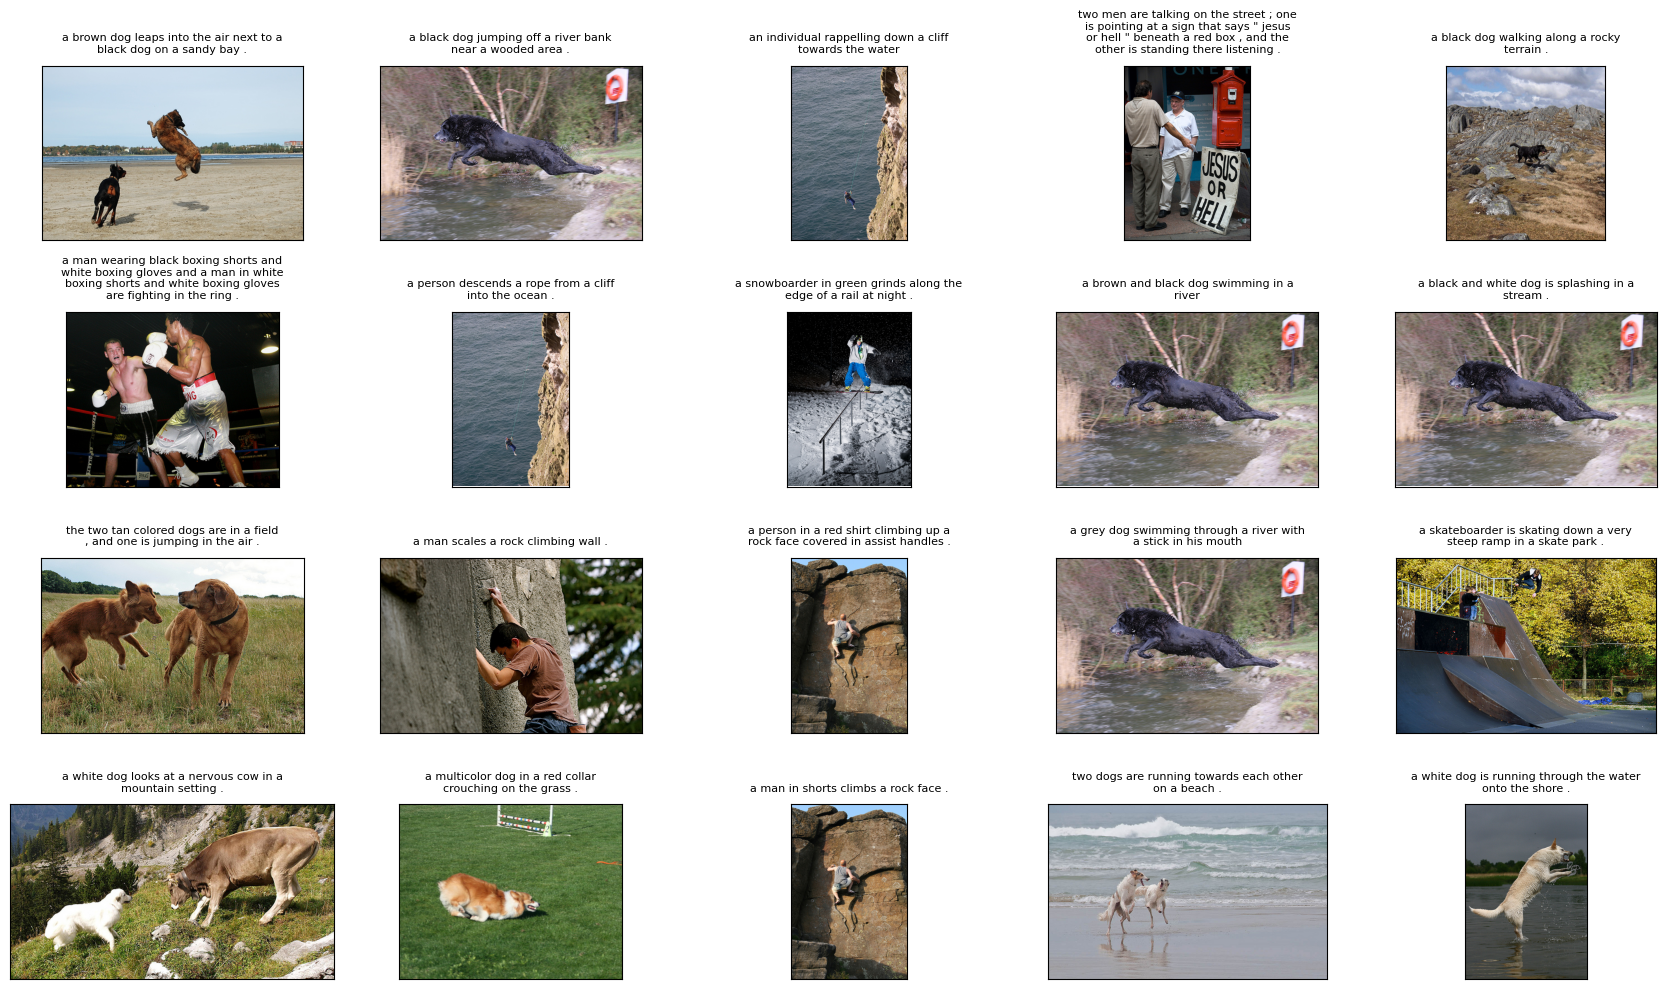

In [73]:
show_examples(test_df)

Модель более-менее неплохо справилась с валидационными данными. Но критерий истинности будет её работа с незнакомыми данными.

# Проверка модели на данных, которые модель ещё не видела

Для удобства мы напишем функцию, способную искать изображение по тексту для одного изображения.

Что должна делать функция:

- Получать текст
- Возвращать картинку и метрику близости.
- Выдавать дисклеймер если запрос некорректный

А затем нужно 10 раз применить функцию к 10 случайным запросам.

Т.е. функция должна работать с любым запросом. Поэтому векторизацию запроса мы делаем в теле функции. А вот векторизацию изображений лучше сделать заранее.

Внутри функции должны выполняться векторизация текста + получение 100 пар (вектор текста + вектор изображения).
Для каждой пары получаем предсказание модели и выбираем пару с наивысшей оценкой соотвтствия.

In [74]:
def model_testing(q,model_name):
    model=dict_classifiers[model_name]
    data=pd.DataFrame()
    data['query_text']=[q]
    data=content_filter(data)
    data=vextrize_description(data)
    vdf=pd.DataFrame(columns=['file','query_text','is_censored','text_features','img_features','path'])
    for img in range(len(tst_img_df)):
        vdf.loc[len(vdf)]=(pd.Series([
                                        tst_img_df.iloc[img]['file'],
                                        data.iloc[0]['query_text'],
                                        data.iloc[0]['is_censored'],
                                        data.iloc[0]['text_features'],
                                        tst_img_df.iloc[img]['img_features'],
                                        tst_img_df.iloc[img]['path']
                                    ], index=vdf.columns))
    vdf=count_vec_dist(vdf)
    X_test=np.array(vdf[['evql','mnh','chbsh','cos']])


    if model_name == 'Pytorch_net':
        X_test = torch.tensor(X_test, dtype=torch.float32).cuda()
        predz=model.forward(X_test)
        vdf['predict']=predz.cpu().detach().numpy()
    else:
        predz=model.predict(X_test)
        vdf['predict']=predz
    maax=max(vdf['predict'])
    goal=vdf[vdf['predict']==maax]
    return goal


In [75]:
tst=pd.read_csv(PATH+'test_queries.csv', sep="|")
tst=tst[['query_text']]
tst=tst.drop_duplicates()
tst.sample(5)

query_text
296  An Afican American woman standing behind two s...
368  People are watching a race car speed thorugh t...
228  Closeup of a man at an event with formal attire .
184   Woman with glasses working at a sewing machine .
186  A girl in a black cape with a group of other c...

In [76]:
tst_img_df=verctorize_files('test_images')
tst_img_df.sample(5)

Batches: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


img_features                                               path                       file
97  [-0.13282785, 0.07595581, 0.06106209, 0.277996...  E:/Data/_Projects/datasets/dsplus_integrated_p...   973827791_467d83986e.jpg
68  [-0.31190675, 0.3787219, -0.06900883, 0.182728...  E:/Data/_Projects/datasets/dsplus_integrated_p...  3455405300_aa3069ecaa.jpg
39  [0.06787428, 0.35836098, 0.2415844, -0.1157082...  E:/Data/_Projects/datasets/dsplus_integrated_p...  3030079705_0dee8a3e89.jpg
88  [-0.06315698, -0.029945977, 0.28005546, -0.225...  E:/Data/_Projects/datasets/dsplus_integrated_p...   440190907_bf8b7ba8ef.jpg
55  [0.05478903, 0.059993953, -0.05865831, 0.40006...  E:/Data/_Projects/datasets/dsplus_integrated_p...  3247693965_845b3b4349.jpg

In [77]:
test_query_list=list(tst['query_text'].unique()[:20])
net_out=pd.DataFrame(columns=['file','query_text','is_censored','text_features','img_features','path','predict'])
tree_out=pd.DataFrame(columns=['file','query_text','is_censored','text_features','img_features','path','predict'])
for qy in test_query_list:
    net_out=pd.concat([net_out,model_testing(qy,'Pytorch_net')])
    tree_out=pd.concat([tree_out,model_testing(qy,'CatBoost')])

100%|██████████| 100/100 [00:00<00:00, 6674.47it/s]


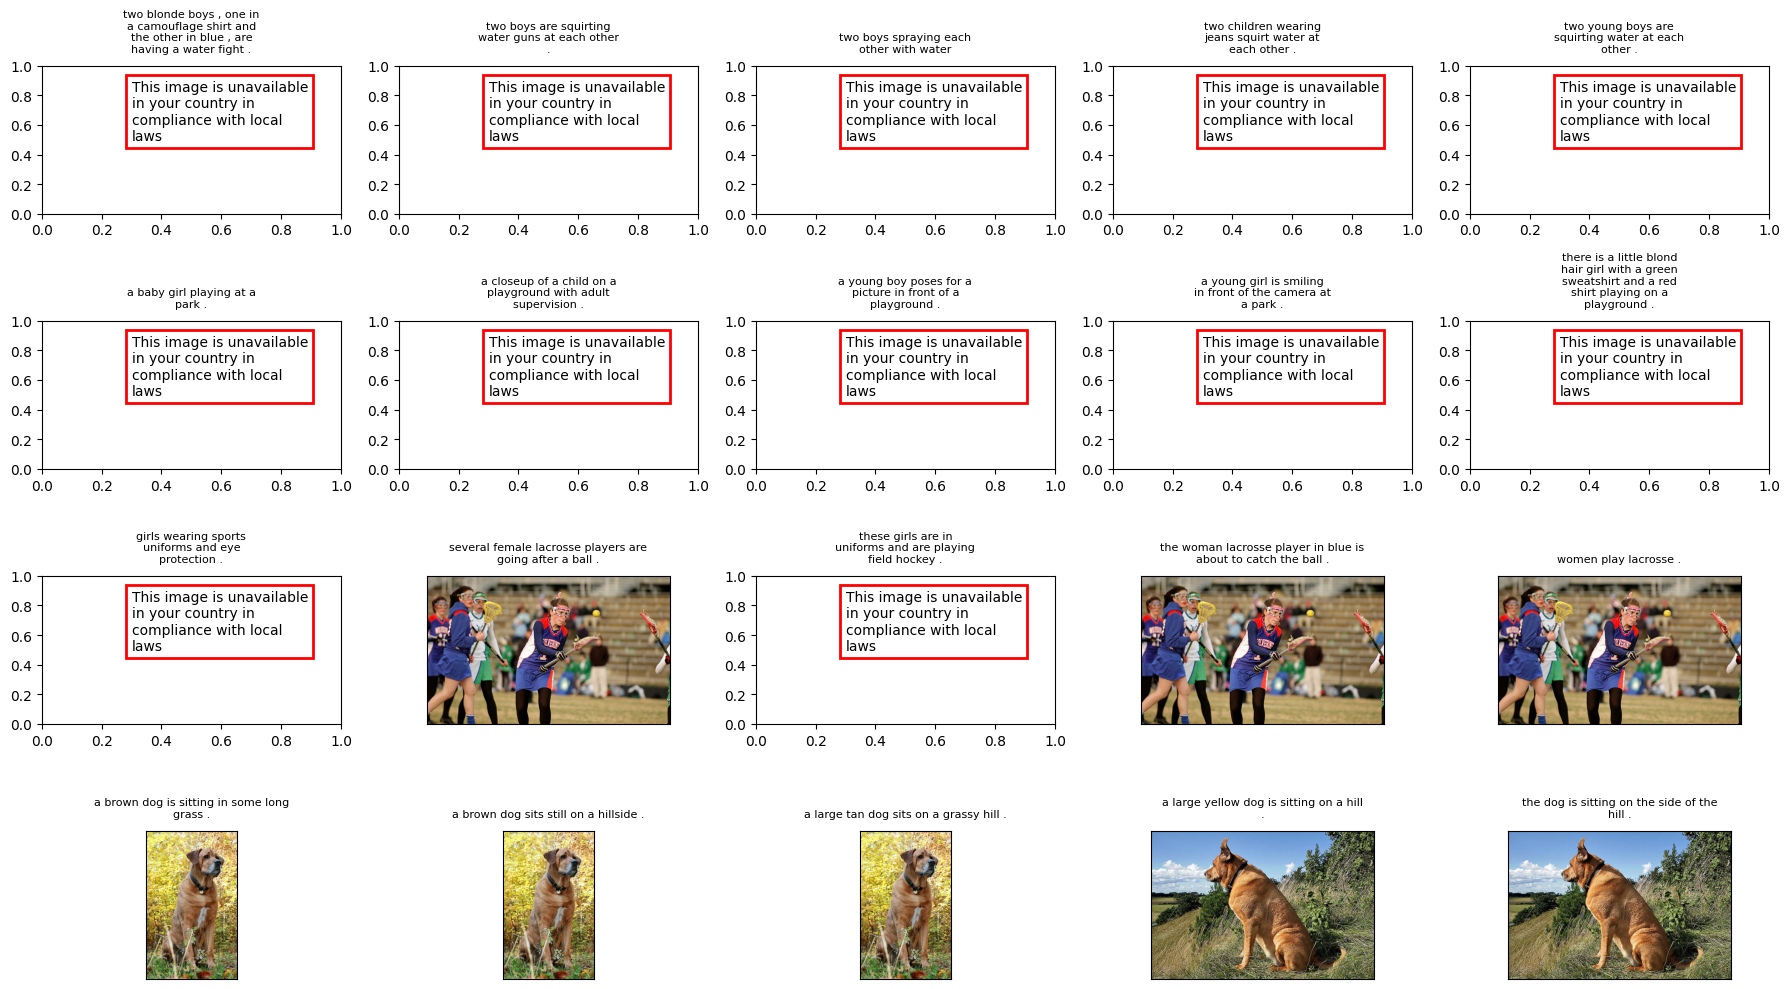

In [78]:
show_examples(net_out)

Результаты нейросети даже на тестовой выборке вполне неплохие. Картинки соответствуют описаниям, и детский контент не просачивается.

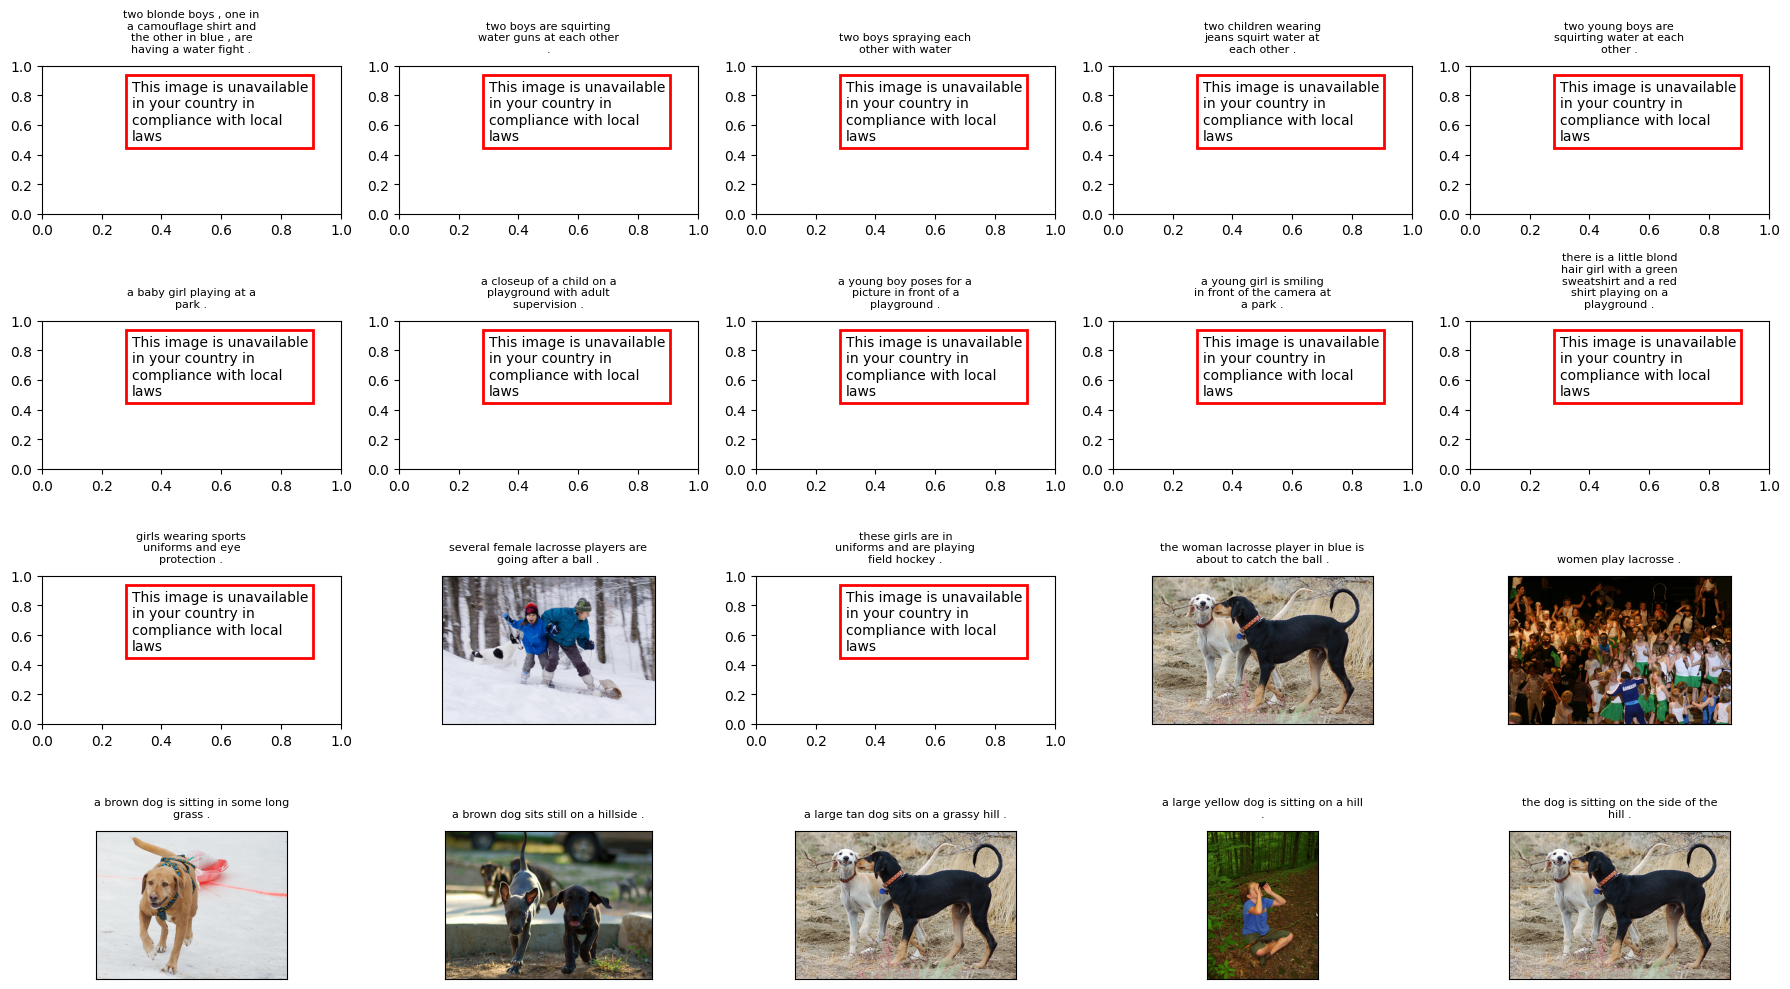

In [79]:
show_examples(tree_out)

А вот CatBoost модель, показавшая лучшую метрику МАЕ справилась с задачей гораздо хуже . Остаётся только попробовать на что способна библиотека SentenceTransformer на базе CLIP. Причём ей даже не нужен будет обучающий набор данных. Она по векторам сама решает какие картинки подходят к каким описаниям.

In [80]:
img_names = list(glob.glob(PATH+'test_images'+'/*.jpg'))
img_emb = model.encode([PIL.Image.open(filepath) for filepath in img_names], convert_to_tensor=True, show_progress_bar=True)

Batches: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


In [81]:
def search(query, k=3):
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    hits = util.semantic_search(query_emb, img_emb, top_k = k)[0]
    dict = {}

    i=0
    for hit in hits:
        params = {}
        idx=hit['corpus_id']

        if any(word in stopset for word in query.lower().split()):
            params['pic'] = 'censored'
            params['xlabel'] = query
            params['title'] = 'This image is unavailable in your country in compliance with local laws'

        else:
            params['pic']=PIL.Image.open(tst_img_df.iloc[idx]['path'])
            params['xlabel']=tst_img_df.iloc[idx]['file']
            params['title']=query
        i = i + 1
        dict[str(query) + str(i)] = params
    return dict

In [82]:
test_query_list = list(tst['query_text'].unique()[-20:])
gross_dic = []
for qy in test_query_list:
    gross_dic.append(search(qy,k=2))

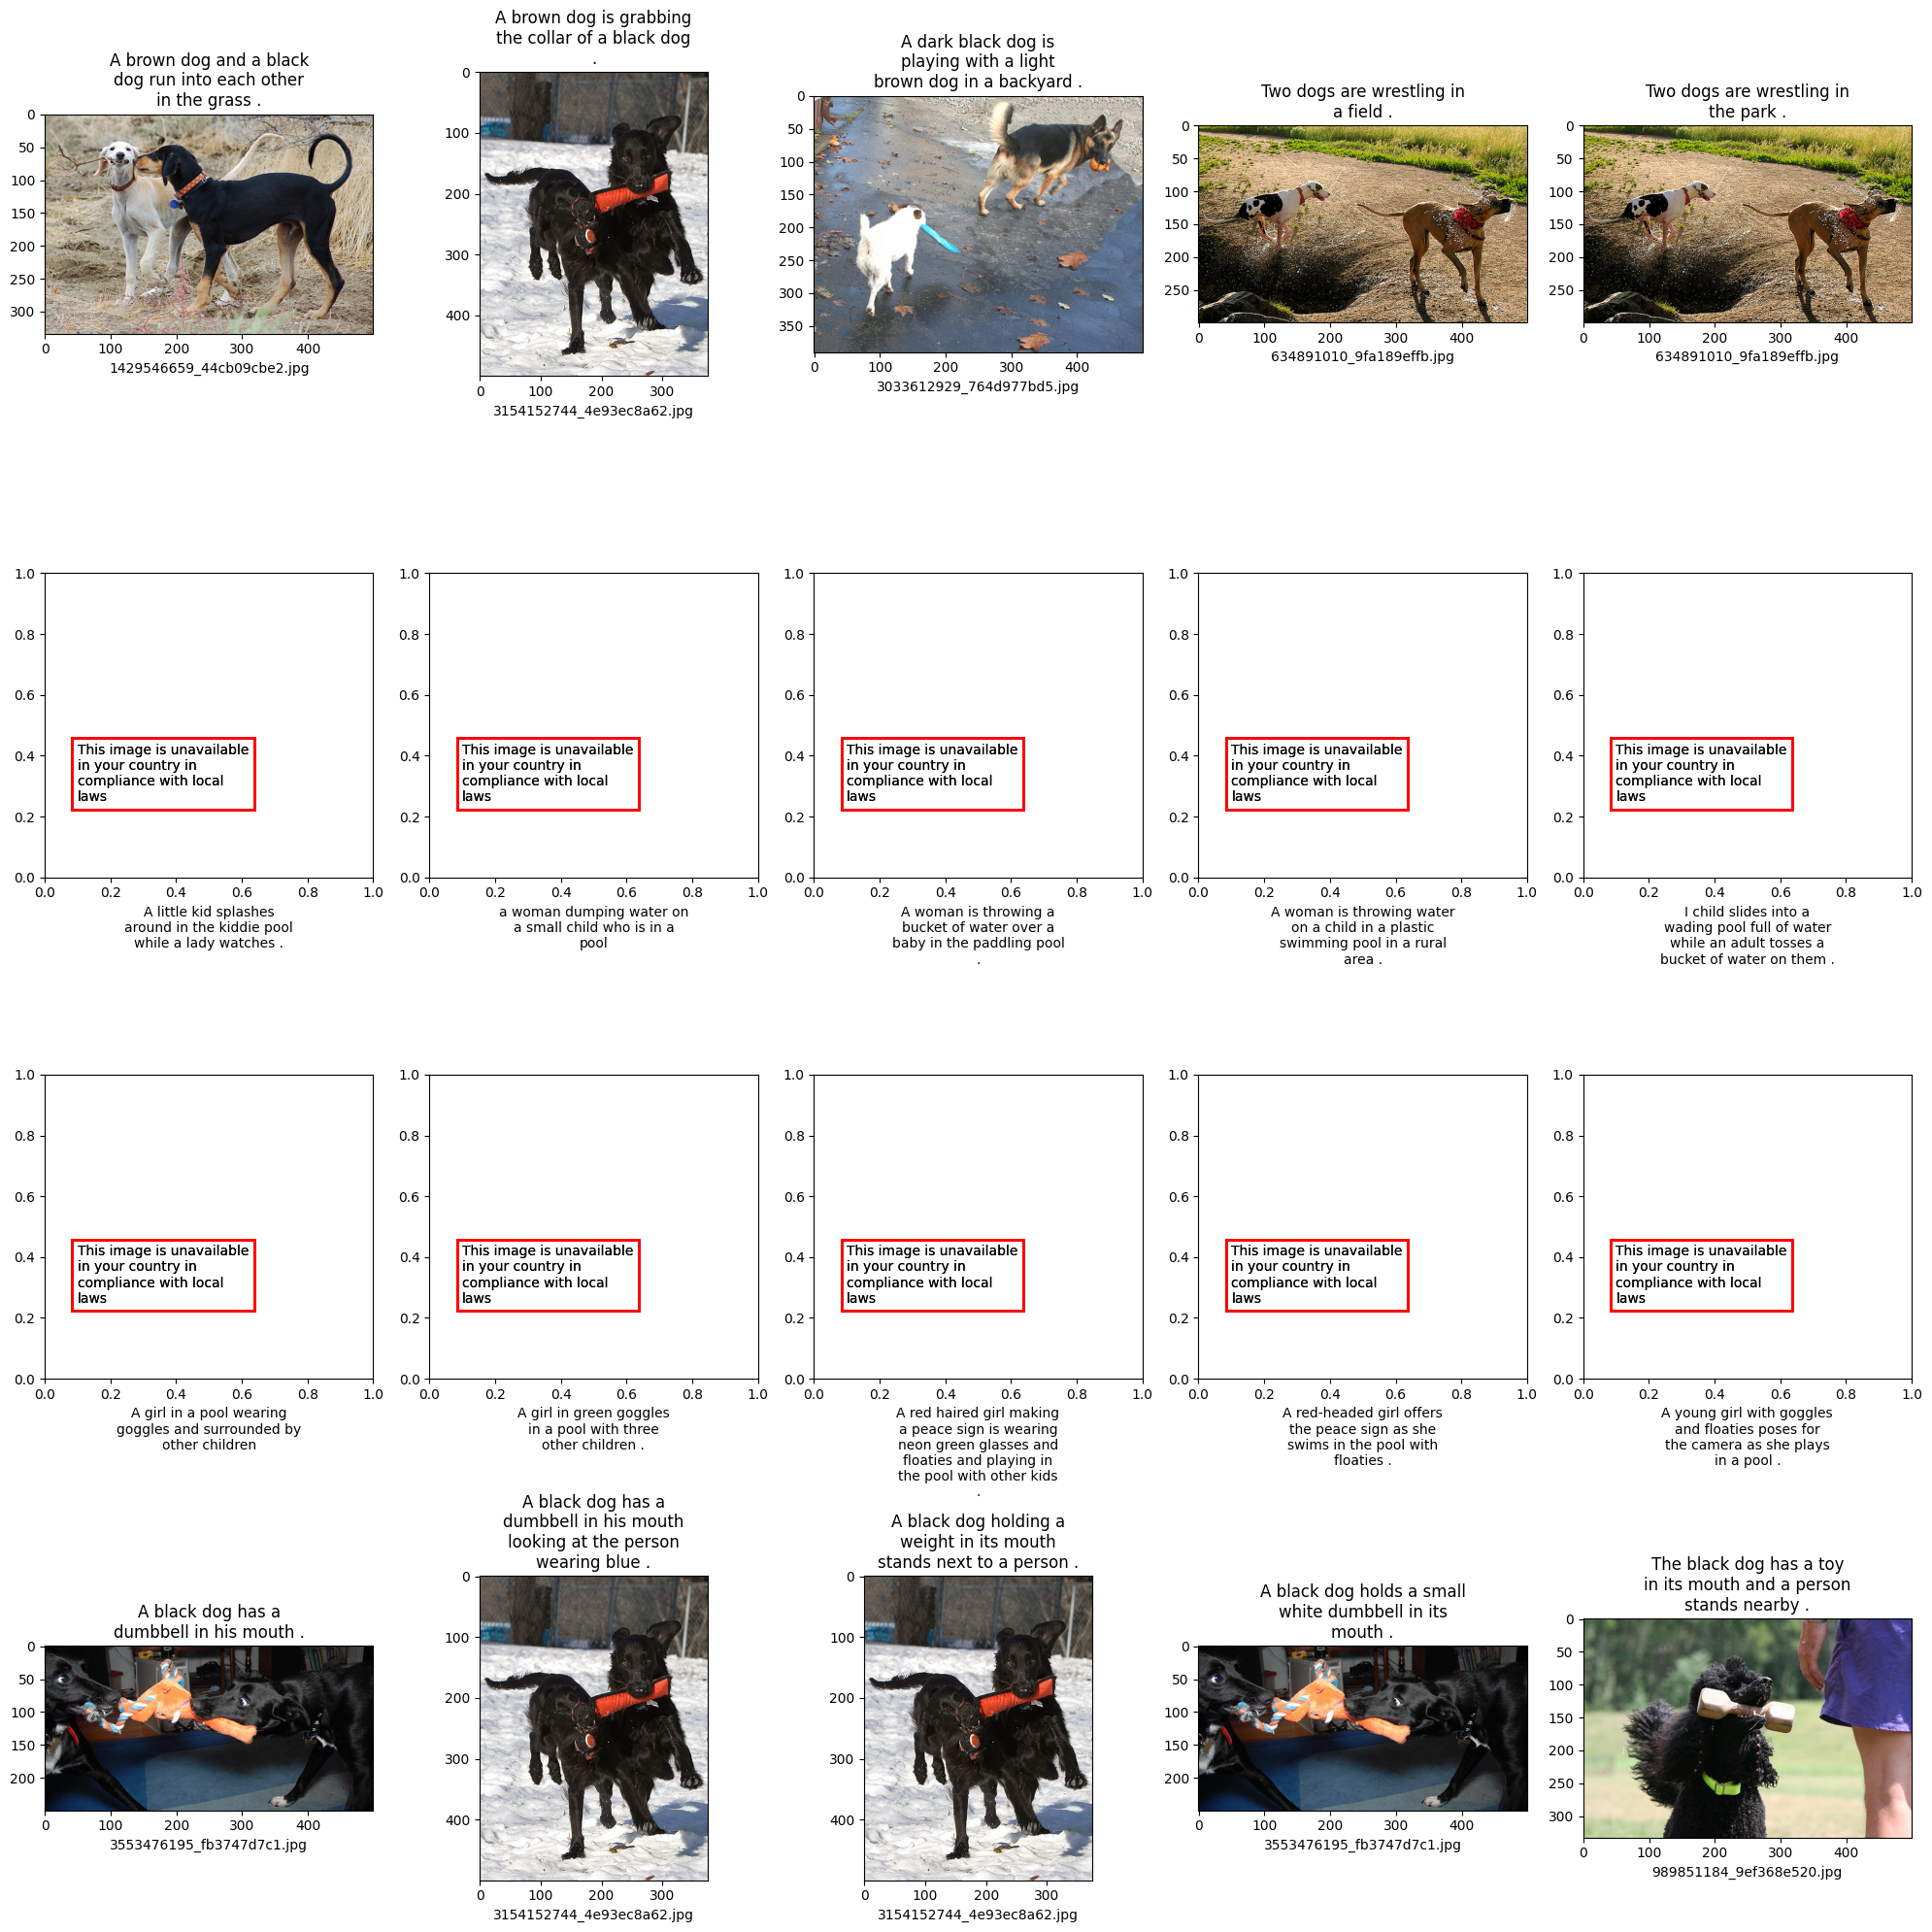

In [83]:
fig = plt.figure(figsize = (20,20))
i=0
for dic in gross_dic:
    fig.add_subplot(4, 5, i + 1)
    for key in dic.keys():
        pars=dic[key]
        if pars['pic'] == 'censored':
            plt.text(0.1, 0.25, "\n".join(wrap(pars['title'],25)), fontsize=10, bbox=dict(fill=False, edgecolor='red', linewidth=2))
            plt.xlabel("\n".join(wrap(pars['xlabel'],25)))
            plt.tight_layout()
        else:
            plt.imshow(pars['pic'])
            plt.xlabel("\n".join(wrap(pars['xlabel'],25)))
            plt.title("\n".join(wrap(pars['title'],25)))
            plt.tight_layout()
    i = i + 1


**Вывод:**  
- Был проведёт первичный анализ обучающего набора данных.
- На основе оценок толпы и оценок экспертов была синтезерована комплексаная оценка соотвествия картинок и их описаний в обучающем наборе.
- Картинки и их описания были преобразованы в вектора с помощью билиотеки SentenceTransformer.
- Были посчитаны разные расстояния между векторами изображений и текстовых описаний и переданы на вход модели.
- Был обучен ряд моделей, показавших себя не с лучшей стороны MAE было не лучше чем у прямолинейных алгоритов.
- Несмотря на это, обученная нейросеть вполне неплохо справилась с подбором картинок по описаниям из тестовой выборки. Собавки были определены как собаки, а женская компанда - как женская команда.
- Модель на  CatBoost пропускает детский контент, в том случае если ребёнок не указан в описании, предложенных описания походят к картинками лишь в некотрой части и в редких случаях.  
- - Модель на базе Pytorch подобрала описания к картинкам из тестового набора очень хорошо, хотя при этом МАЕ у неё было не самое лучшее.
Видимо дело в том, что МАЕ чувствительно к выбросам, а подавляющее большинство пар имеет сводную оценку близкую к нулю. А то что модель должна искать, это как раз выбросы.
- Зато встроенные методы библиотеки SentenceTransformer показали хороший результат с тестовыми данными, несмотря на то, что модель даже не видела тренировочный набор.

